In [ ]:
# 23-12-06 : NSGA II algorithm implemented

In [ ]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
# Initialize random population of parent chormosomes/solutions P
def random_population(n_var, n_sol, lb, ub):
    # n_var = numver of variables
    # n_sol = number of random solutions
    # lb = lower bound
    # ub = upper bound
    pop = np.zeros((n_sol, n_var))
    for i in range(n_sol):
        pop[i,:] = np.random.uniform(lb, ub)

    return pop

In [ ]:
# On each iteration, out of 2 randomly selected parents we create 2 offsprings
# by taking fraction of genes from one parent and remaining fraction from other parent
def crossover(pop, crossover_rate):
    offspring = np.zeros((crossover_rate, pop.shape[1]))
    for i in range(int(crossover_rate/2)):
        r1 = np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        cutting_point = np.random.randint(1, pop.shape[1])
        offspring[2*i, 0:cutting_point] = pop[r1, 0:cutting_point]
        offspring[2*i, cutting_point:] = pop[r2, cutting_point:]
        offspring[2*i+1, 0:cutting_point] = pop[r2, 0:cutting_point]
        offspring[2*i+1, cutting_point:] = pop[r1, cutting_point:]

    return offspring    # arr(crossover_size x n_var)

In [ ]:
# On each iteration, out of 2 randomly selected parents we create 2 offsprings
# by excahging some amount of genes/coordinates between parents
def mutation(pop, mutation_rate):
    offspring = np.zeros((mutation_rate, pop.shape[1]))
    for i in range(int(mutation_rate/2)):
        r1 = np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        # We select only one gene/coordinate per chromosomes/solution for mutation here.
        # For binary solutions, number of genes for mutation can be arbitrary
        cutting_point = np.random.randint(0, pop.shape[1])
        offspring[2*i] = pop[r1]
        offspring[2*i, cutting_point] = pop[r2, cutting_point]
        offspring[2*i+1] = pop[r2]
        offspring[2*i+1, cutting_point] = pop[r1, cutting_point]

    return offspring    # arr(mutation_size x n_var)

In [ ]:
# Create some amount of offsprings Q by adding fixed coordinate displacement to some
# randomly selected parent's genes/coordinates
def local_search(pop, n_sol, step_size):
    # number of offspring chromosomes generated from the local search
    offspring = np.zeros((n_sol, pop.shape[1]))
    for i in range(n_sol):
        r1 = np.random.randint(0, pop.shape[0])
        chromosome = pop[r1, :]
        r2 = np.random.randint(0, pop.shape[1])
        chromosome[r2] += np.random.uniform(-step_size, step_size)
        if chromosome[r2] < lb[r2]:
            chromosome[r2] = lb[r2]
        if chromosome[r2] > ub[r2]:
            chromosome[r2] = ub[r2]

        offspring[i,:] = chromosome
    return offspring    # arr(loc_search_size x n_var)

In [ ]:
# Calculate fitness (obj function) values for each chormosome/solution
# Kursawe function - https://en.wikipedia.org/wiki/Test_functions_for_optimization
def evaluation(pop):
    fitness_values = np.zeros((pop.shape[0], 2)) # 2 values for each choromosome/solution
    for i,x in enumerate(pop):
        obj1 = 0
        for j in range(2):
            obj1 += - 10*math.exp(-0.2*math.sqrt((x[j])**2 + (x[j+1])**2))

        obj2 = 0
        for j in range(3):
            obj2 += (abs(x[j]))**0.8 + 5*math.sin((x[j])**3)

        fitness_values[i,0] = obj1
        fitness_values[i,1] = obj2

    return fitness_values   # arr(pop_size x 2)

In [ ]:
# Estimate how tightly clumped fitness values are on Pareto front.
def crowding_calculation(fitness_values):
    pop_size = len(fitness_values[:, 0])
    fitness_value_number = len(fitness_values[0, :])                    # == n of objective functions
    matrix_for_crowding = np.zeros((pop_size, fitness_value_number))    # arr(pop_size x 2)
    normalized_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)  # arr.ptp(0) array of max elem in each col

    for i in range(fitness_value_number):
        crowding_results = np.zeros(pop_size)
        crowding_results[0] = 1 # extreme point has the max crowding distance
        crowding_results[pop_size - 1] = 1 # extreme point has the max crowding distance
        sorted_normalized_fitness_values = np.sort(normalized_fitness_values[:,i])
        sorted_normalized_values_index = np.argsort(normalized_fitness_values[:,i])
        # crowding distance calculation. Say for fitness1[i], crowding = fitness1[i+1] - fitness1[i-1]
        crowding_results[1:pop_size - 1] = (sorted_normalized_fitness_values[2:pop_size] - sorted_normalized_fitness_values[0:pop_size - 2])
        re_sorting = np.argsort(sorted_normalized_values_index)
        matrix_for_crowding[:, i] = crowding_results[re_sorting]

    crowding_distance = np.sum(matrix_for_crowding, axis=1) # on fitness1 - fitness2 plot, each point on pareto front has crowding distance number

    return crowding_distance    # arr(pop_size,)

In [ ]:
# Crowding distance is used to maintain diversity of solutions on Pareto front.
# Remove some amount of solutions that are clumped together to much
def remove_using_crowding(fitness_values, number_solutions_needed):
    pop_index = np.arange(fitness_values.shape[0])
    crowding_distance = crowding_calculation(fitness_values)
    selected_pop_index = np.zeros(number_solutions_needed)
    selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))    # arr(num_sol_needed x 2)
    for i in range(number_solutions_needed):
        pop_size = pop_index.shape[0]
        solution_1 = rn.randint(0, pop_size - 1)
        solution_2 = rn.randint(0, pop_size - 1)
        if crowding_distance[solution_1] >= crowding_distance[solution_2]:
            # solution 1 is better than solution 2
            selected_pop_index[i] = pop_index[solution_1]
            selected_fitness_values[i, :] = fitness_values[solution_1, :]
            pop_index = np.delete(pop_index, (solution_1), axis=0)
            fitness_values = np.delete(fitness_values, (solution_1), axis=0)
            crowding_distance = np.delete(crowding_distance, (solution_1), axis=0)
        else:
            # solution 2 is better than solution 1
            selected_pop_index[i] = pop_index[solution_2]
            selected_fitness_values[i, :] = fitness_values[solution_2, :]
            pop_index = np.delete(pop_index, (solution_2), axis=0)
            fitness_values = np.delete(fitness_values, (solution_2), axis=0)
            crowding_distance = np.delete(crowding_distance, (solution_2), axis=0)

    selected_pop_index = np.asarray(selected_pop_index, dtype=int)

    return selected_pop_index   # arr(n_sol_needed,)

In [ ]:
# find indices of solutions that dominate others
def pareto_front_finding(fitness_values, pop_index):
    pop_size = fitness_values.shape[0]
    pareto_front = np.ones(pop_size, dtype=bool)    # all True initially
    for i in range(pop_size):
        for j in range(pop_size):
            if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                pareto_front[i] = 0 # i is not in pareto front becouse j dominates i
                break

    return pop_index[pareto_front]  # arr(len_pareto_front,)

In [ ]:
def selection(pop, fitness_values, pop_size):

    pop_index_0 = np.arange(pop.shape[0])   # unselected pop ids
    pop_index = np.arange(pop.shape[0])     # all pop ids. len = len(pop_size)
    pareto_front_index = []

    while len(pareto_front_index) < pop_size:   # pop_size = initial_pop_size
        new_pareto_front = pareto_front_finding(fitness_values[pop_index_0, :], pop_index_0)
        total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

        # check the size of pareto_front, if larger than pop_size then remove some
        if total_pareto_size > pop_size:
            number_solutions_needed = pop_size - len(pareto_front_index)
            selected_solutions = remove_using_crowding(fitness_values[new_pareto_front], number_solutions_needed)
            new_pareto_front = new_pareto_front[selected_solutions]

        pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
        remaining_index = set(pop_index) - set(pareto_front_index)
        pop_index_0 = np.array(list(remaining_index))

    selected_pop = pop[pareto_front_index.astype(int)]

    return selected_pop     # arr(pop_size x n_var)

In [ ]:
# Parameters
n_var = 3                   # chromosome has 3 coordinates/genes
lb = [-5, -5, -5]
ub = [5, 5, 5]
pop_size = 10              # initial number of chormosomes
rate_crossover = 5        # number of chromosomes that we apply crossower to
rate_mutation = 5         # number of chromosomes that we apply mutation to
rate_local_search = 5      # number of chromosomes that we apply local_search to
step_size = 0.1             # coordinate displacement during local_search
maximum_generation = 10    # number of iterations
pop = random_population(n_var, pop_size, lb, ub)    # initial parents population P
print(pop.shape)

(10, 3)


In [ ]:
pop

array([[ 4.80472378, -4.35979152,  0.95013433],
       [ 0.07143218,  4.25969938,  3.83183533],
       [ 0.28912384,  3.71499637,  0.79612112],
       [ 2.27958965,  2.87497984,  3.59801014],
       [-2.33635181, -2.77122972, -1.33448292],
       [-1.69017461,  4.07039111, -1.06938904],
       [ 0.7937036 ,  1.71099248, -4.92270411],
       [-2.87645747, -3.37841941,  0.47536258],
       [ 1.38604445,  1.96751656,  4.31694712],
       [-1.54057841, -2.25811872,  4.72221579]])

In [ ]:
# NSGA-II main loop
for i in range(maximum_generation):
    offspring_from_crossover = crossover(pop, rate_crossover)
    offspring_from_mutation = mutation(pop, rate_mutation)
    offspring_from_local_search = local_search(pop, rate_local_search, step_size)

    # we append childrens Q (cross-overs, mutations, local search) to paraents P
    # having parents in the mix, i.e. allowing for parents to progress to next iteration - Elitism
    pop = np.append(pop, offspring_from_crossover, axis=0)
    pop = np.append(pop, offspring_from_mutation, axis=0)
    pop = np.append(pop, offspring_from_local_search, axis=0)
    print(pop.shape)
    fitness_values = evaluation(pop)
    pop = selection(pop, fitness_values, pop_size)  # we arbitrary set desired pereto front size = pop_size
    print('iteration:', i)

(25, 3)
(40, 3)
(55, 3)
(70, 3)
(85, 3)
(100, 3)
(115, 3)
(130, 3)
(145, 3)
(160, 3)


In [ ]:
fitness_values = evaluation(pop)
index = np.arange(pop.shape[0]).astype(int)
pareto_front_index = pareto_front_finding(fitness_values, index)
pop = pop[pareto_front_index, :]
print("_________________")
print("Optimal solutions:")
print("       x1               x2                 x3")
print(pop) # show optimal solutions

_________________
Optimal solutions:
       x1               x2                 x3
[[-1.11972805e+00 -1.06631858e+00 -1.10257817e+00]
 [ 3.68510944e-04 -3.31512355e-04 -1.03324138e+00]
 [-1.08609161e+00 -8.36193224e-01 -1.05416299e+00]
 [-1.06982104e+00 -1.02619536e+00 -1.08714292e+00]
 [-1.03843424e+00 -3.31512355e-04 -8.77616349e-01]
 [ 3.68510944e-04 -3.31512355e-04 -1.14800415e+00]
 [ 3.68510944e-04 -3.31512355e-04 -7.42774164e-01]
 [-1.05057979e+00 -3.31512355e-04 -1.02888769e+00]
 [-1.12367152e+00 -1.02619536e+00 -1.08714292e+00]
 [-1.11972805e+00 -6.64043239e-01 -1.05416299e+00]
 [-1.09805437e+00 -3.31512355e-04 -6.02857444e-01]
 [ 3.68510944e-04 -3.31512355e-04 -1.14800415e+00]
 [-1.03843424e+00 -3.31512355e-04 -8.68105028e-01]
 [ 3.68510944e-04 -3.31512355e-04 -1.12519961e+00]
 [-1.04375271e+00 -3.31512355e-04 -1.02888769e+00]
 [-1.05057979e+00 -3.31512355e-04 -1.05416299e+00]
 [-1.04375271e+00 -3.31512355e-04 -9.97493961e-01]
 [-1.04375271e+00 -3.31512355e-04 -9.39262061e-01]

In [ ]:
fitness_values = fitness_values[pareto_front_index]

In [ ]:
print("Fitness values:")
print("  objective 1    objective 2")
print(fitness_values)

Fitness values:
  objective 1    objective 2
[[-14.69819181 -11.25211089]
 [-18.13206518  -3.43304866]
 [-15.24286565  -9.17991525]
 [-14.84989073 -10.76591018]
 [-16.51479274  -5.69512895]
 [-17.9475168   -3.8714586 ]
 [-18.61853598  -1.20039653]
 [-16.24504384  -6.94941239]
 [-14.79165871 -10.96290371]
 [-15.50213465  -8.12184082]
 [-16.89244831  -4.18877955]
 [-17.9475168   -3.8714586 ]
 [-16.53076827  -5.61741759]
 [-17.98385202  -3.84424995]
 [-16.25611796  -6.90878123]
 [-16.20399876  -7.10466862]
 [-16.30738863  -6.68954648]
 [-16.40334661  -6.23448515]
 [-18.61853598  -1.20039653]
 [-15.933102    -7.72124631]
 [-18.6753376   -0.9873989 ]
 [-14.72547479 -11.10991946]
 [-16.15263929  -7.27771473]
 [-15.29070048  -8.92426224]
 [-14.75554937 -11.05687355]
 [-15.04642158 -10.01579182]
 [-17.99559768  -3.82789433]
 [-16.32512495  -6.60882165]
 [-15.47902628  -8.22469098]
 [-18.40516284  -2.14621033]
 [-16.7229424   -4.62591534]
 [-16.21444098  -7.04262037]
 [-15.34528663  -8.68040787

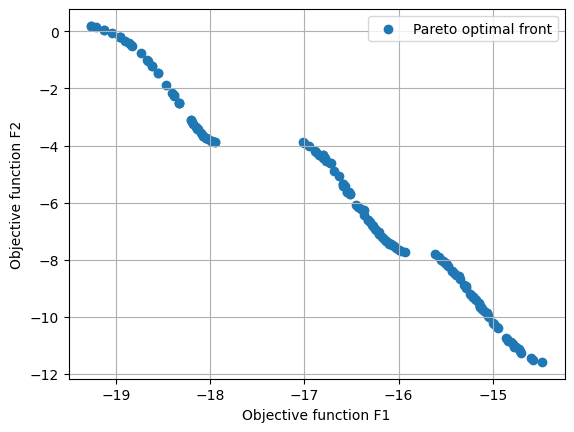

In [ ]:
plt.scatter(fitness_values[:, 0],fitness_values[:, 1], label='Pareto optimal front')
plt.legend(loc='best')
plt.xlabel('Objective function F1')
plt.ylabel('Objective function F2')
plt.grid()
plt.show()